In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data
df = pd.read_parquet('data/Syn-training.parquet')
df = pd.concat([df, pd.read_parquet('data/DNS-testing.parquet')])
df = pd.concat([df, pd.read_parquet('data/UDP-testing.parquet')])
df['Label'].value_counts()

Label
Syn          43302
Benign       32110
DrDoS_UDP    10420
DrDoS_DNS     3669
Name: count, dtype: int64

In [2]:
# mpa each label to a number
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['Label'])
df['Label'] = le.transform(df['Label'])

In [3]:
# perform LDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Label', axis=1), df['Label'], test_size=0.2, random_state=42)

# perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# make predictions
y_pred = lda.predict(X_test)

# calculate accuracy
accuracy_score(y_test, y_pred)

0.9724037763253449

<Axes: >

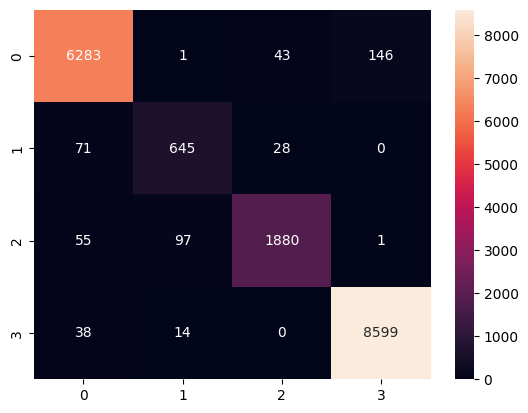

In [4]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [5]:
# calculate the accuracy for each class
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))


Precision:  [0.97456181 0.85204756 0.96360841 0.98319232]
Recall:  [0.9706473  0.86693548 0.92474176 0.99398913]
F1:  [0.97260062 0.85942705 0.9437751  0.98856125]


<Axes: title={'center': 'Predicted Labels'}, ylabel='count'>

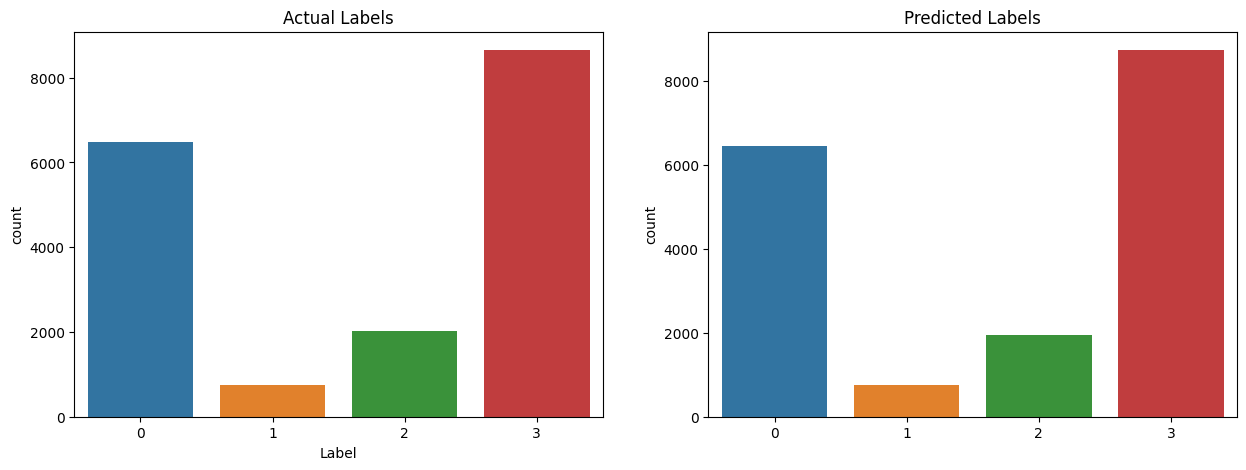

In [6]:
# plot side by side the actual and predicted labels
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Actual Labels')
# If using all scalar values, you must pass an index
sns.countplot(x=y_test)
plt.subplot(1, 2, 2)
plt.title('Predicted Labels')
sns.countplot(x=y_pred)

In [7]:
# use the trained model to predict the label of all the samples in a new dataset
df_example = pd.read_parquet('data/Syn-training.parquet')
df_example = pd.concat([df_example, pd.read_parquet('data/DNS-testing.parquet')])
df_example = pd.concat([df_example, pd.read_parquet('data/UDP-testing.parquet')])


# mpa each label to a number using the same encoder
df_example['Label'] = le.transform(df_example['Label'])

# make predictions
y_pred = lda.predict(df_example.drop('Label', axis=1))
print(y_pred)
print(len(y_pred))

[3 3 3 ... 0 0 0]
89501


In [8]:
df_example['Label'].value_counts()

Label
3    43302
0    32110
2    10420
1     3669
Name: count, dtype: int64

In [9]:
len(df_example['Label'])

89501

<Axes: >

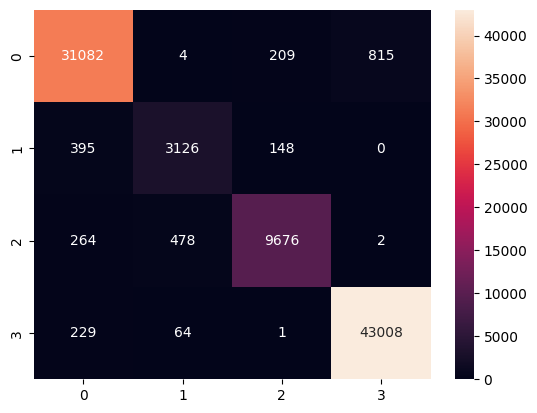

In [10]:
# plot the confusion matrix
cm = confusion_matrix(df_example['Label'], y_pred)
sns.heatmap(cm, annot=True, fmt='d')


In [11]:
# from df_example, drop only the samples where y_pred is 0
df_example['lda'] = y_pred
df_example = df_example[df_example['lda'] != 0]
df_example['Label'].value_counts()

Label
3    43073
2    10156
1     3274
0     1028
Name: count, dtype: int64

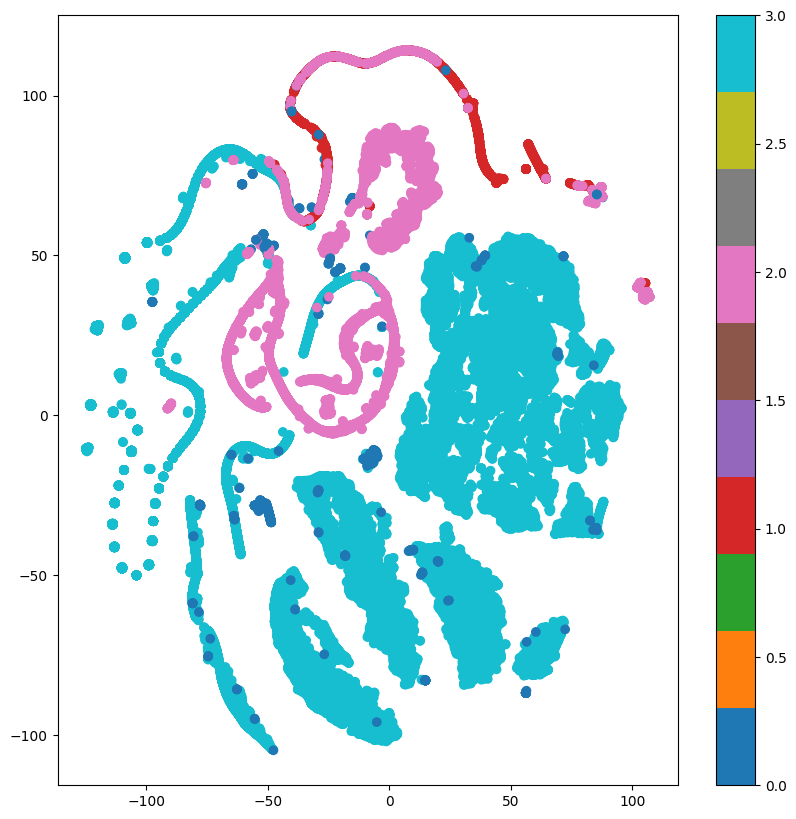

In [12]:
# perform t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100)
X_embedded = tsne.fit_transform(df_example.drop(['Label', 'lda'], axis=1))

# plot the data
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df_example['Label'], cmap='tab10')
plt.colorbar()



In [13]:
# use this dataset to train a random forest classifier
from sklearn.ensemble import RandomForestClassifier

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_example.drop(['Label', 'lda'], axis=1), df_example['Label'], test_size=0.2, random_state=42)

# train the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# make predictions
y_pred = rf.predict(X_test)


<Axes: >

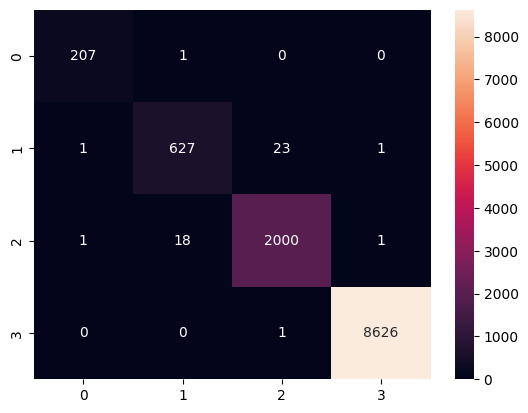

In [14]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')



In [15]:
# calculate the accuracy for each class
print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))


Precision:  [0.99043062 0.97058824 0.98814229 0.9997682 ]
Recall:  [0.99519231 0.96165644 0.99009901 0.99988408]
F1:  [0.99280576 0.96610169 0.98911968 0.99982614]
